<h1 style="color:black;text-align:center;font-size:300%;font-family:verdana;">
Support Vector Regressor
</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import GridSearchCV
from IPython.display import display
# removes unnecessary warnings (for nicer looking graphs)
import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('clean_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527232 entries, 0 to 527231
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Origin                             527232 non-null  object
 1   Destination                        527232 non-null  object
 2   TTT                                527232 non-null  int64 
 3   LOS                                527232 non-null  int64 
 4   Arrival Time                       527232 non-null  object
 5   Return Arrival Time                527232 non-null  object
 6   Onward Departure Airport           527232 non-null  object
 7   Onward Arrival Airport             527232 non-null  object
 8   Return Departure Airport           527232 non-null  object
 9   Return Arrival Airport             527232 non-null  object
 10  Onward Airlines                    527232 non-null  object
 11  Return Airlines                    527232 non-null  

## Correlation-Based Feature Selection & Analysis
Before building the model, we will start with the top 10 correlating features with the price for a baseline model.  
Later, we will test adding more features and compare the performance using evaluation tools (R², MAE, RMSE).

### Steps:  
1. Select only numeric features.
2. Remove constant columns.
3. Compute correlations with price.
4. Visualize correlations with a heatmap.

This helps identify key predictors and remove irrelevant features.  

📌 Correlation between numeric variables and flight price:
Price(NIS)                           1.000000
Total Flight Duration(min)           0.439293
Total Onward Flight Duration(min)    0.409827
Total Return Flight Duration(min)    0.386589
Carry-ons                            0.198557
Departure Month                      0.081097
Checked Bags                         0.039901
Total Connections                    0.038113
Onward Flight Connections            0.027944
Return Flight Connections            0.027640
Return Month                         0.015533
Departure Weekday                   -0.000305
Onward Connection Duration(min)     -0.001828
Return Connection Duration(min)     -0.002180
LOS                                 -0.004541
Departure Time Category Num         -0.018463
Return Time Category Num            -0.042170
Return Weekday                      -0.042786
Return Departure Airport Distance   -0.061253
TTT                                 -0.062268
Return Arrival Airport

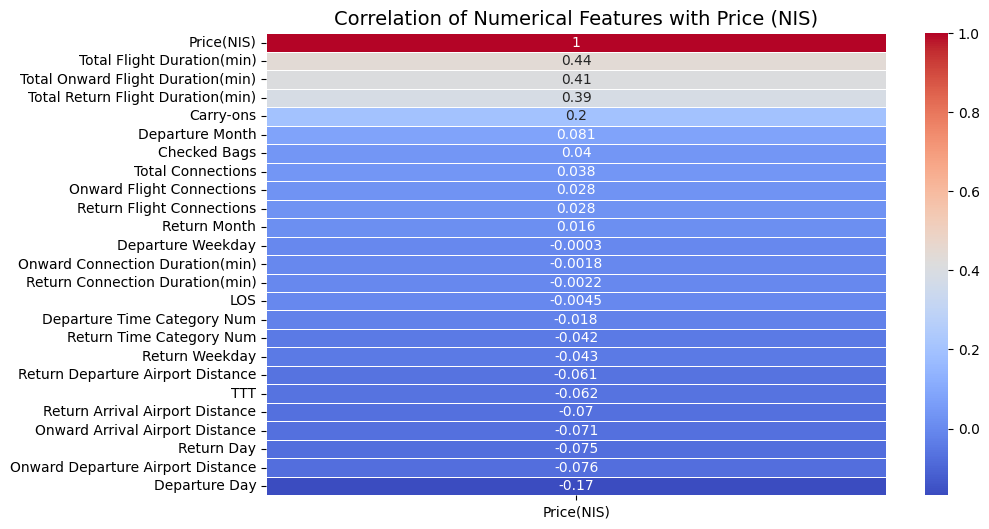

In [3]:
# Selecting only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Removing constant columns (columns with only one unique value)
numeric_data = numeric_data.loc[:, numeric_data.nunique() > 1]

print("📌 Correlation between numeric variables and flight price:")
correlation_with_price = numeric_data.corr()['Price(NIS)'].sort_values(ascending=False)
print(correlation_with_price)

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr()[['Price(NIS)']].sort_values(by='Price(NIS)', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation of Numerical Features with Price (NIS)", fontsize=14)
plt.show()

In [4]:
correlation_with_price = abs(correlation_with_price).sort_values(ascending=False)
correlation_with_price.head(12)

Price(NIS)                           1.000000
Total Flight Duration(min)           0.439293
Total Onward Flight Duration(min)    0.409827
Total Return Flight Duration(min)    0.386589
Carry-ons                            0.198557
Departure Day                        0.168935
Departure Month                      0.081097
Onward Departure Airport Distance    0.076258
Return Day                           0.074558
Onward Arrival Airport Distance      0.070608
Return Arrival Airport Distance      0.070343
TTT                                  0.062268
Name: Price(NIS), dtype: float64

In [5]:
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Preparation  

Before training the model, we define the features (X) and target variable (y).  
We must also scale the numerical data because we want even weights between the different features.    
SVR works best with with data centered around mean = 0, variance = 1 so we use the standard scaler.

### Steps:  
1. Select all relevant features. 
2. Convert the nominal features into categories and create dummies so that the model will be able to understand them properlly.   
3. Split the data into training (70%) and testing (30%) sets.  
4. Print dataset sizes to verify the split.  
5. Scale the features for both X_train and X_test

This ensures the model is trained on one part of the data and evaluated on unseen data.  


In [6]:
X = data[[
    "Total Onward Flight Duration(min)", "Total Return Flight Duration(min)", "Carry-ons",
    "Departure Day", "Departure Month", "Onward Departure Airport Distance", "Return Day",
    "Onward Arrival Airport Distance", "Return Arrival Airport Distance", "TTT"
]]  
y = data["Price(NIS)"]
X.head()

,Total Onward Flight Duration(min),Total Return Flight Duration(min),Carry-ons,Departure Day,Departure Month,Onward Departure Airport Distance,Return Day,Onward Arrival Airport Distance,Return Arrival Airport Distance,TTT
0,70,65,0,7,3,64,8,25,45,1
1,70,75,0,7,3,64,8,25,23,1
2,70,65,0,7,3,64,8,25,45,1
3,70,70,0,7,3,64,8,25,45,1
4,70,70,0,7,3,64,8,25,45,1


### * Since the features we picked are all numeric, there is no need to convert any into categories.

In [7]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (369062, 10), Test set: (158170, 10)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Initial Support Vector Model
- Train a basic **Support Vector Regressor**.  
- Predict flight prices on the test set.  
- Evaluate performance using **MAE**, **MSE** and **R² Score**. 


In [9]:
# svr_model = SVR(kernel='rbf', C=1.0, epsilon=1.0)
# svr_model.fit(X_train_scaled, y_train)

# # predictions
# y_pred = svr_model.predict(X_test_scaled)

# # Checking Model Performance
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred, squared=False)
# rmse = math.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R² Score: {r2:.4f}")

❗ After trying to train the standard model for over 50 minutes, we checked wether this long training period is normal.  
  
❌ We decided to stop the training after discovering that the algorithms run time is between `O(n^2 * m)` and `O(n^3 * m)`.  
  
💡 We though of a different approach where we split the data into batches, training each batch to find support vectors seperatly and then train a final SVR on the collected support vectors.



In [10]:
# batch_size = 5000  # Adjust based on available memory
# n_batches = int(np.ceil(len(X) / batch_size))

# X_scaled = scaler.fit_transform(X)  # Scale entire dataset

# all_support_vectors = []
# all_support_y = []

# for i in range(n_batches):
#     print(f"Processing batch {i+1}/{n_batches}...")
    
#     # Get batch data
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, len(X))
    
#     X_batch = X_scaled[start_idx:end_idx]
#     y_batch = y[start_idx:end_idx]
#     y_batch = np.array(y_batch)
    
#     # Train SVR on batch
#     svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
#     svr.fit(X_batch, y_batch)
    
#     # Extract support vectors
#     support_indices = svr.support_
#     all_support_vectors.append(X_batch[support_indices])
#     all_support_y.append(y_batch[support_indices])

# # Combine all collected support vectors
# X_support_combined = np.vstack(all_support_vectors)
# y_support_combined = np.hstack(all_support_y)

# # Train final SVR model using the collected support vectors
# final_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# final_svr.fit(X_support_combined, y_support_combined)

# print("Final SVR model trained on collected support vectors.")

❗ This too did not work so well and we decided to stop the process mid-way again.  

💡 We learned that the `rbf` kurnel handles non-linear relationships, following intricate data patterns, thus predicting a very precise hyperplane.  
Is not suited for large datasets due to large complexity times like we encountered. 

💡The `LinearSVD`, altough slightly less precise, is preffered to handling these situations due to it's simpler approach that uses linear regression  
with epsilon-insensitive loss, that scales linearly with the number of samples.



In [11]:
svr_model = LinearSVR(C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# predictions
y_pred = svr_model.predict(X_test_scaled)

# Checking Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (TMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 129.03
Mean Squared Error (MSE): 31571.26
Root Mean Squared Error (TMSE): 177.68
R² Score: 0.2644


### Due to very low scores, we want to see for ourselves the models predictions:

In [12]:
# Creating a DataFrame with actual vs. predicted prices
comparison_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred
})

# Adding an error column (difference between actual and predicted)
comparison_df["Error"] = comparison_df["Predicted Price"] - comparison_df["Actual Price"]

# Adding an indicator column for over/under prediction
comparison_df["Prediction Direction"] = np.where(
    comparison_df["Error"] > 0, "⬆ Over", "⬇ Under"
)

# Styling: align all columns to center
styled_table = (comparison_df
                .head(10)
                .style
                .set_properties(**{'text-align': 'center'})  # Apply to all columns
                .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])  # Center column headers
)

# Display the table
display(styled_table)

,Actual Price,Predicted Price,Error,Prediction Direction
0,761,738.001589,-22.998411,⬇ Under
1,632,592.248463,-39.751537,⬇ Under
2,433,501.168681,68.168681,⬆ Over
3,740,353.686176,-386.313824,⬇ Under
4,1162,675.925325,-486.074675,⬇ Under
5,446,712.067372,266.067372,⬆ Over
6,944,664.145975,-279.854025,⬇ Under
7,529,611.603889,82.603889,⬆ Over
8,832,708.683974,-123.316026,⬇ Under
9,631,647.043591,16.043591,⬆ Over


### Trying to search for the best hyper parameters to improve performance:

In [13]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(LinearSVR(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 1, 'epsilon': 0.5}


In [14]:
svr_model = LinearSVR(**grid_search.best_params_)
svr_model.fit(X_train_scaled, y_train)

# predictions
y_pred = svr_model.predict(X_test_scaled)

# Checking Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 129.03
Mean Squared Error (MSE): 31605.17
Root Mean Squared Error (RMSE): 177.78
R² Score: 0.2636


## **Final Thoughts** 
* Even after tuning using hyperparameters, our metrics show us that the performance of `LinearSVR` is very poor.

* We scaled our data so high noise should not be the cause for these results.

* We can infer that the reason is due to us using a linear model with features that correlate quite poorly with the target feature(non-linear relationships).

* Continuing to try different ways to maximize the algorithm's performance is an option but due to the very low start point  
we prefer to try a different algorithm that is perhaps more suited to our data.
___
